In [1]:
import scipy.interpolate as interp
from ruspy.estimation.estimation_transitions import create_transition_matrix
from ruspy.model_code.cost_functions import calc_obs_costs
from ruspy.model_code.cost_functions import lin_cost
from ruspy.model_code.fix_point_alg import calc_fixp

In [2]:
# Load data. This step will be replaced when we have different data.
df = performance_dataframe()
df_sorted = df.loc[(slice(None), "average_three_dim"), :].reset_index(drop=True).drop(["p_0", "p_1", "p_2"], axis=1)

# Processing

Process the simulated data to get a combined probablity and omega grid as well as their simulated values.

In [3]:
# Set all stratgies simulated. Later this should reflect the whole range between 0 and 1.
omega_strategies = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# Read out the simulated probability grid from the data.
grid_probs = df_sorted.loc[:, ["p_0_true", "p_1_true", "p_2_true"]].to_numpy()

In [4]:
# Create container for the combined simulated grid of probailities and omegas
work_grid = np.array([[0, 0, 0]])
values = np.array([])
for omega in omega_strategies:
    edit_grid = grid_probs
    edit_grid[:, 2] = omega
    work_grid = np.append(work_grid, grid_probs, axis=0)
    values = np.append(values, df_sorted.loc[:, omega].to_numpy(), axis=0)
# Kick out the initialization row
grid = work_grid[1:, :]

# Evaluation grid

Now creat an evaluation grid on which we will later interpolate the performance and then apply the decision criteria.

In [5]:
def create_eval_prob_omega_grid(prob_gridsize, omega_grid):
    """
    This function creates for an arbitray probability and omega gridsize,
    the grid which will later be evaluated i.e. the values interpolated.
    """
    vectors = []
    # The probabilities go from 0 to 1
    x = y = np.arange(0.01, 1, prob_gridsize)
    for omega in omega_grid:
        for p_1 in x:
            for p_2 in y:
                if p_1 == 0 or p_2 == 0:
                    pass
                elif p_1 + p_2 >= 1:
                    pass
                else:
                    vectors += [[p_1, p_2, omega]]
    return np.array(vectors).round(2)

In [6]:
# The omega grid only to the maximum selected omega.
omega_grid = np.arange(0, 0.51, 0.01)
eval_grid = create_eval_prob_omega_grid(0.01, omega_grid)

# Interpolation and apply criteria

In [7]:
# Interpolate the evaluation grid.
interpol_vals = interp.griddata(grid, values, eval_grid, method="linear")

In [8]:
# Reshape evaluation grid and values such that they are sorted by omega
omega_eval_grid = eval_grid.reshape(len(omega_grid), int(eval_grid.shape[0] / len(omega_grid)), 3)
omega_values = interpol_vals.reshape(len(omega_grid), int(eval_grid.shape[0] / len(omega_grid)))

## Minimax

In [9]:
# Now get min for each omega. Replace nans with 0 as all values are negative, this will not conflict 
# with choosing minimum. The nans are there becaus the evaulation grid goes beyond the simulated probability grid.
# Something we could avoid, but not necessary needed.
omegas_min = np.min(np.nan_to_num(omega_values, nan=0), axis=1)
omegas_min

array([-83859.99010979, -83859.78756997, -83859.58503016, -83859.38249035,
       -83859.17995053, -83858.97741072, -83858.7748709 , -83858.57233109,
       -83858.36979128, -83858.16725146, -83857.96471165, -83857.92045262,
       -83857.8761936 , -83857.83193457, -83857.78767555, -83857.74341652,
       -83857.6991575 , -83857.65489847, -83857.61063944, -83857.56638042,
       -83857.52212139, -83857.48774878, -83857.45337617, -83857.41900356,
       -83857.38463096, -83857.35025835, -83857.31588574, -83857.28151313,
       -83857.24714052, -83857.21276791, -83857.1783953 , -83857.17196709,
       -83857.16553889, -83857.15911068, -83857.15268248, -83857.14625428,
       -83857.13982607, -83857.13339787, -83857.12696966, -83857.12054146,
       -83857.11411325, -83857.11208642, -83857.11005958, -83857.10803274,
       -83857.1060059 , -83857.10397907, -83857.10195223, -83857.09992539,
       -83857.09789855, -83857.09587172, -83857.09384488])

In [10]:
# Get argmax omega
omega_grid[np.argmax(omegas_min)]

0.5

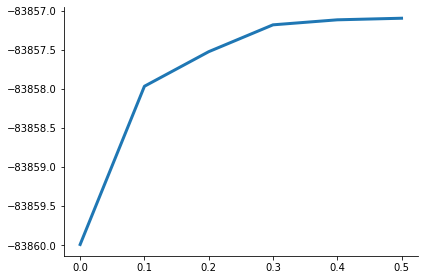

In [11]:
fig, ax = plt.subplots()
ax.plot(omega_grid, omegas_min)

## Subjective Bayes

In [12]:
omegas_mean = np.nanmean(omega_values, axis=1)
omegas_mean

array([-60190.86773862, -60191.36055434, -60191.78406429, -60192.12119062,
       -60192.36067833, -60192.4898167 , -60192.49589502, -60192.36620257,
       -60192.08802864, -60191.64804226, -60194.40948473, -60193.33079417,
       -60194.13700296, -60194.98679398, -60195.86753952, -60196.76661181,
       -60197.67138312, -60198.5692257 , -60199.44751182, -60200.29361372,
       -60202.66736114, -60203.47159812, -60204.8303998 , -60206.18330454,
       -60207.54078036, -60208.91413413, -60210.31467271, -60211.75370297,
       -60213.24253177, -60214.79330482, -60213.60348308, -60216.73880964,
       -60218.30557867, -60219.82790911, -60221.29364602, -60222.69021465,
       -60224.00504026, -60225.22554811, -60226.33916345, -60227.33289174,
       -60228.17260425, -60225.41029111, -60227.9710333 , -60230.40944699,
       -60232.77631729, -60235.12215193, -60237.49745861, -60239.95274504,
       -60242.53851894, -60245.30528801, -60248.30355995])

In [13]:
# Get argmax 
omega_grid[np.argmax(omegas_mean)]

0.0

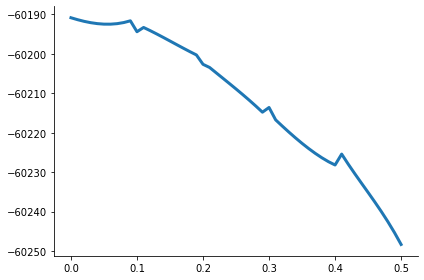

In [14]:
fig, ax = plt.subplots()
ax.plot(omega_grid, omegas_mean)

## Minimax regret

In [15]:
# # Create regret on each grid point. This takes quite some time
# num_states = 40
# obs_costs = calc_obs_costs(num_states, lin_cost, np.array([50, 400]), 0.001)
# regrets = np.empty_like(interpol_vals)
# for i, grid_point in enumerate(eval_grid):
#     prob = np.append(grid_point[:2], 1 - np.sum(grid_point[:2]))
#     trans_mat = create_transition_matrix(num_states, prob)
#     ev_ml, _, _ = calc_fixp(trans_mat, obs_costs, 0.9999)
#     regrets[i] = ev_ml[0] - interpol_vals[i]

In [16]:
# regrets_omega = regrets.reshape(len(omega_grid), int(regrets.shape[0] / len(omega_grid)))

In [17]:
# fig, ax = plt.subplots()
# ax.plot(omega_grid, np.nanmin(regrets_omega, axis=1))